In [33]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('../../')

import matplotlib.pyplot as plt
import numpy as np
import Phys
# physical constants in cgs units
constants = Phys.ReadPhys()

from SpecWizard_Input import ReadData
from SpecWizard_BuildInput import Build_Input
from SpecWizard_ProjectData import SightLineProjection
from SpecWizard_ComputeOpticaldepth import ComputeOpticaldepth



In [34]:
BI     = Build_Input()
Wizard = BI.read_from_yml("Wizard.yml")

Warning! SightLength NOT found. Setting default value : 1


In [35]:
snapshot  = ReadData(wizard = Wizard)
particles = snapshot.read_particles()

In [36]:
sightlineprojection  = SightLineProjection(Wizard)
projected_LOS        = sightlineprojection.ProjectData(particles)

In [37]:
cspec          = ComputeOpticaldepth(Wizard)
opticaldepth   = cspec.MakeAllOpticaldepth(projected_LOS)

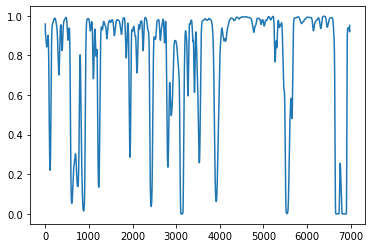

In [38]:
plt.plot(np.exp(-opticaldepth[('Hydrogen', 'H I')]['Optical depths']['Value']))

In [39]:
ions = opticaldepth.keys()

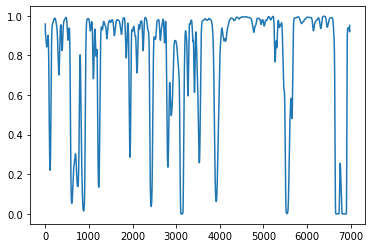

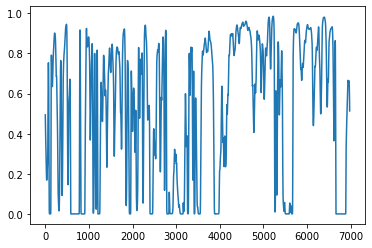

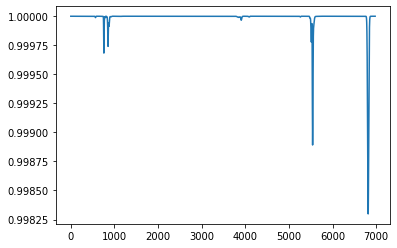

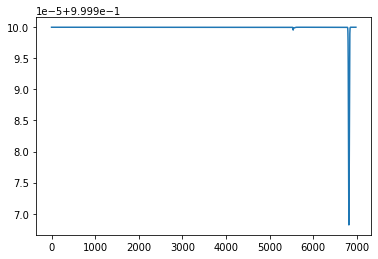

In [40]:
for ion in ions:
    plt.plot(np.exp(-opticaldepth[ion]['Optical depths']['Value']))
    plt.show()
